In [41]:
import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
import GPy
from gpr4im import fg_tools as fg
from gpr4im import pk_tools as pk
from gpr4im import obs_tools as obs
168.5
base = '/home/ppxjf3/bright_source_removal/'

fits_path = base + 'GLMv2_LoBES03Mar2022_combine.fits'

hdul = fits.open(fits_path)

data = hdul[1].data
hdul.info()
hdul.close()

Filename: /home/ppxjf3/bright_source_removal/GLMv2_LoBES03Mar2022_combine.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU    308   345886R x 103C   ['11A', '36A', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', '11A', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', '3A', 'D', 'D', 'D', 'D', 'D', 'D', 'D']   


In [42]:
#cut so just primary beam
def primary_beam(data):
    idx0 = 2048//2 - 512//2

    idx1 = 2048//2 + 512//2
    pixel_size = idx1 -idx0


    return data[:,idx0:idx1, idx0:idx1] 

In [43]:
nan_idx = np.argwhere(np.isnan(data['ALPHA_PL']))

In [44]:
ra = data['RA']
print(ra)

[ 18.40535754  17.46737245  15.58108728 ... 204.15570068 359.69766235
 359.79257202]


In [45]:
dec = data['Dec']
print(dec)

[-34.71430776 -30.28705703 -15.21692854 ... -33.95689392 -60.88955307
 -60.93148804]


In [6]:
fits_path = '/home/ppxjf3/SKA_Data/ZW3.msn_image.fits'

In [7]:


with fits.open(fits_path, memmap=True) as hdu:
    arr = np.array(hdu[0].data[:,:, :]) #163.5MHz - 168.5 MHz
    hdu.info()
    print(arr.shape)
    arr = primary_beam(arr)
    bmaj=hdu[0].header['BMAJ']

    bmin=hdu[0].header['BMIN']

    psf_degrees = (bmaj+bmin) / 2.0

    psf_radians = psf_degrees * np.pi/180.

    FWHM = psf_radians


Filename: /home/ppxjf3/SKA_Data/ZW3.msn_image.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      67   (2048, 2048, 901)   float32   
(901, 2048, 2048)


In [8]:
# The RA range for this data is 10.49 degrees across 2048 pixels, 
x = ((ra+180)%360 -180)* (2048/10.49)

# The Dec range for this data is 9.07 across 2048 pixels (it is also shifted up by its minimum value -34.33),
y = dec
y = (y + 34.33)*(2048/9.07)

In [9]:
import array as ar

non_nan_x = np.delete(x, nan_idx)

non_nan_flux = np.delete(data['P_FLX166'], nan_idx) #get flux and convert from mJy/beam to Jy/beam

non_nan_y = np.delete(y, nan_idx)

non_nan_alpha = np.delete(data['ALPHA_PL'], nan_idx)

In [10]:
#calc F0 from alpha values

F0 = np.array([])
for i in range(0,len(non_nan_flux)):
    F0 = np.append(F0, (non_nan_flux[i])/(166**non_nan_alpha[i]))

In [11]:
frequency = np.arange(106, 196.1, 0.1)

In [12]:
non_nan_flux= np.empty([len(frequency),len(non_nan_alpha)])
for i in range(0, len(frequency)):
    non_nan_flux[i,:] = F0[:]*frequency[i]**non_nan_alpha[:]

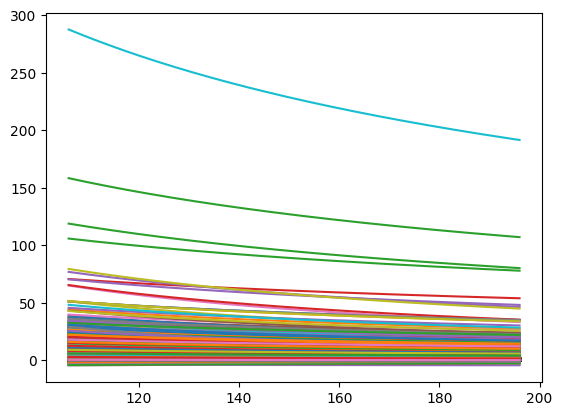

In [13]:
plt.plot(frequency, non_nan_flux)
plt.show()

In [14]:
non_nan_flux.shape

(901, 273919)

In [15]:
indexx = -non_nan_x.astype(int) + 1024
indexy = non_nan_y.astype(int) +46
#gleam_matrix = np.empty((len(frequency),2048,2048))
gleam_matrix = np.empty((len(frequency),2048,2048))

In [16]:
idx0 = 2048//2 - 512//2

idx1 = 2048//2 + 512//2
x_pb = np.array([])
y_pb = np.array([])

for j in range(len(frequency)):
    for i in range(len(indexx)):
            if  idx0 <= indexy[i] < idx1 and  idx0 <= indexx[i] < idx1:
                gleam_matrix[j,indexy[i],indexx[i]] = non_nan_flux[j,i]
                x_pb = np.append(x_pb,indexx[i] -idx0)
                y_pb = np.append(y_pb, indexy[i]-idx0)

        
gleam_matrix = gleam_matrix[:,idx0:idx1,idx0:idx1]        
print(gleam_matrix.shape)


(901, 512, 512)


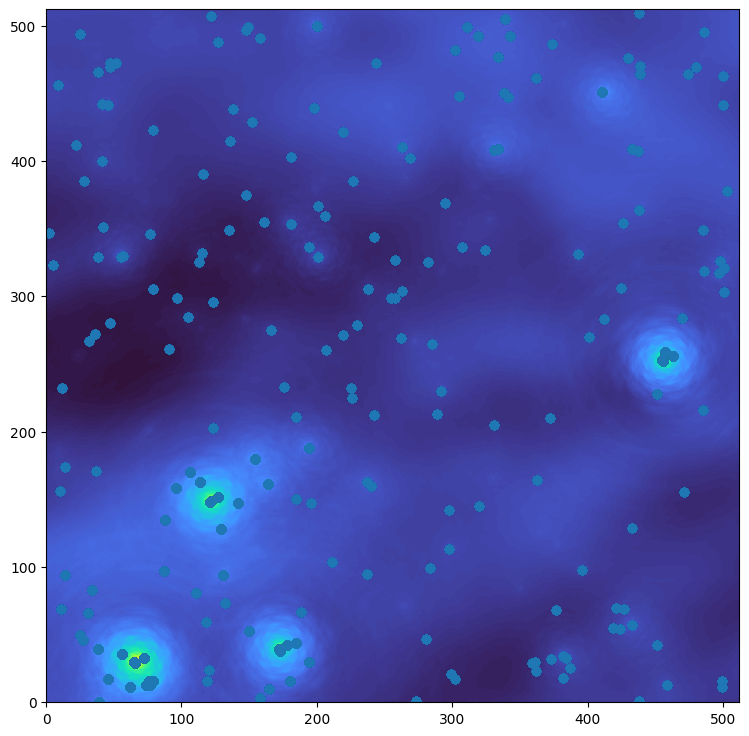

In [17]:
plt.figure(figsize = (9,9))
plt.imshow(arr[25,:,:], cmap = 'turbo')
plt.scatter(x_pb, y_pb )
plt.xlim(0, 512)
plt.ylim(0, 512)
plt.show()

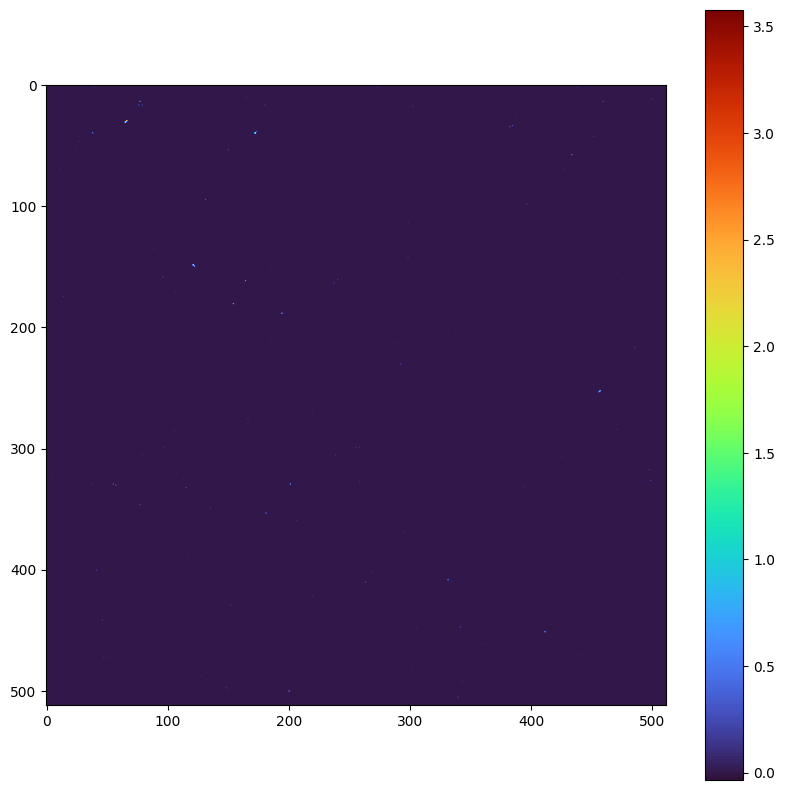

In [18]:


plt.figure(figsize = (10, 10))
plt.imshow(gleam_matrix[0,:,:], cmap = 'turbo')
plt.colorbar()



In [19]:


SKAdata_stationbeam = fits.open(base+"station_beam.fits")
SKAdata_natural_psf = fits.open(base+"ZW3.msn_psf.fits")



In [20]:


stationbeam_data =  primary_beam(SKAdata_stationbeam[0].data[:,256:2304,256:2304])
SKAdata_stationbeam.close()
naturalw_psf = SKAdata_natural_psf[0].data[:,:,:]
SKAdata_natural_psf.close()



In [21]:
naturalw_psf.shape

(901, 2048, 2048)

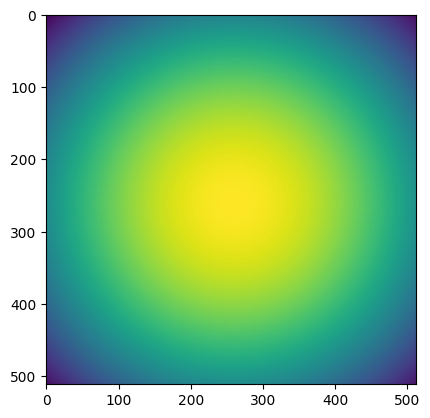

In [22]:


fig, ax = plt.subplots()
ax.imshow(stationbeam_data[25,:,:])



In [23]:


# Cropping the primary beam to be the same size as the GLEAM image:
primarybeam_center = stationbeam_data[:,:,:]



In [24]:


mult_prim_gle = primarybeam_center * gleam_matrix



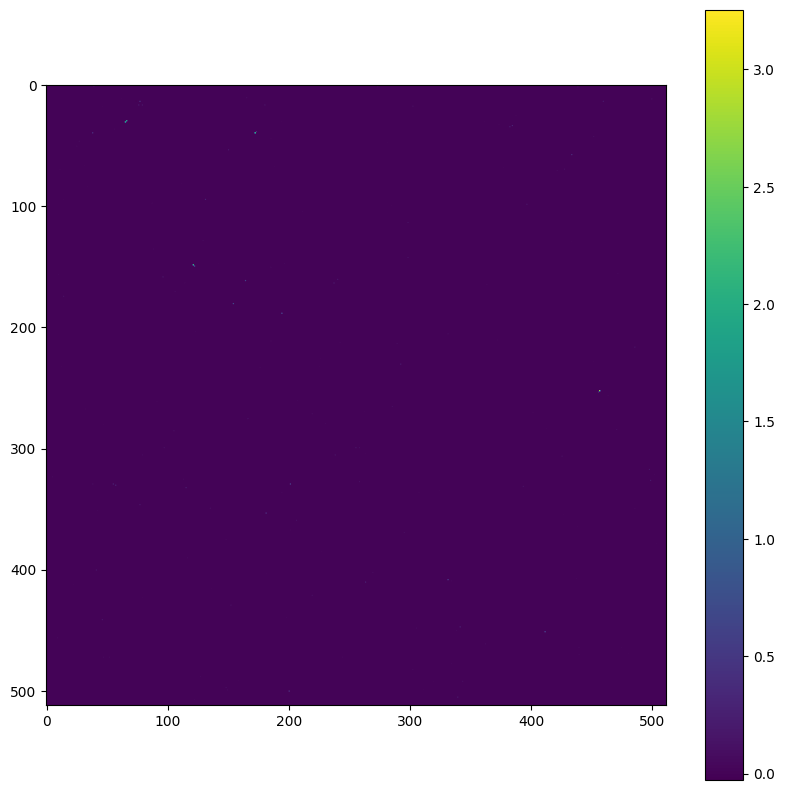

In [25]:


plt.figure(figsize= (10, 10))
plt.imshow(mult_prim_gle[0,:,:])
plt.colorbar()



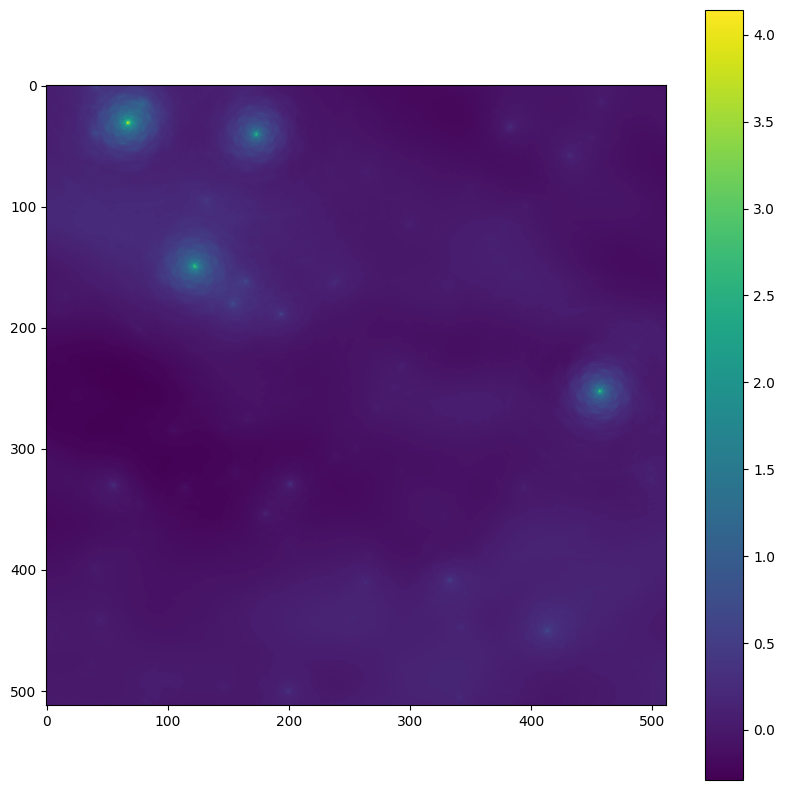

In [26]:

plt.figure(figsize= (10, 10))
#plt.imshow(jyperb_to_k(arr[25,:,:]))
plt.imshow(arr[25,:,:])
plt.colorbar()

In [27]:


convpsf = naturalw_psf[:,:,:] 




In [28]:
import scipy
from scipy import signal

low_res = 0
conv_img1d = np.zeros_like(arr)
for i in range(len(arr)):
    if low_res==0:
        conv_img1d[i,:,:] =scipy.signal.convolve(mult_prim_gle[i,:,:], convpsf[i,:,:], 'same')
    if low_res==1:
        conv_img1d[i,:,:] =scipy.signal.convolve(mult_prim_gle[i,:,:], convpsf[0,:,:], 'same')

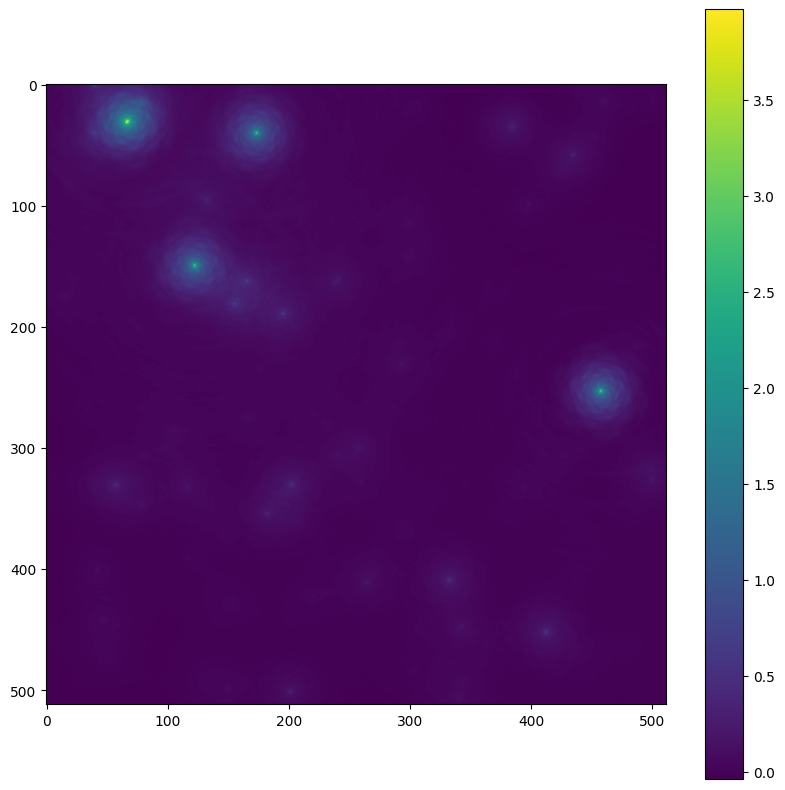

In [29]:


plt.figure(figsize= (10, 10))
plt.imshow(conv_img1d[20,:,:])
plt.colorbar()



In [30]:
print( arr[25,:,:].shape)
print(conv_img1d.shape)
subtract = arr[:,:,:] - conv_img1d
print(subtract.shape)

(512, 512)
(901, 512, 512)
(901, 512, 512)


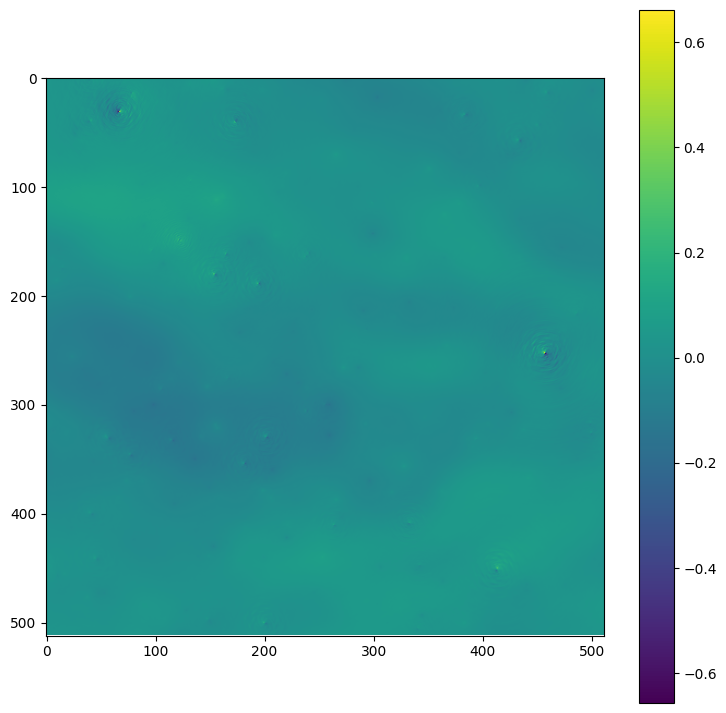

In [31]:
plt.figure(figsize=(9, 9))
plt.imshow(subtract[400,:,:])
plt.colorbar()
plt.show()
subtract_img = subtract

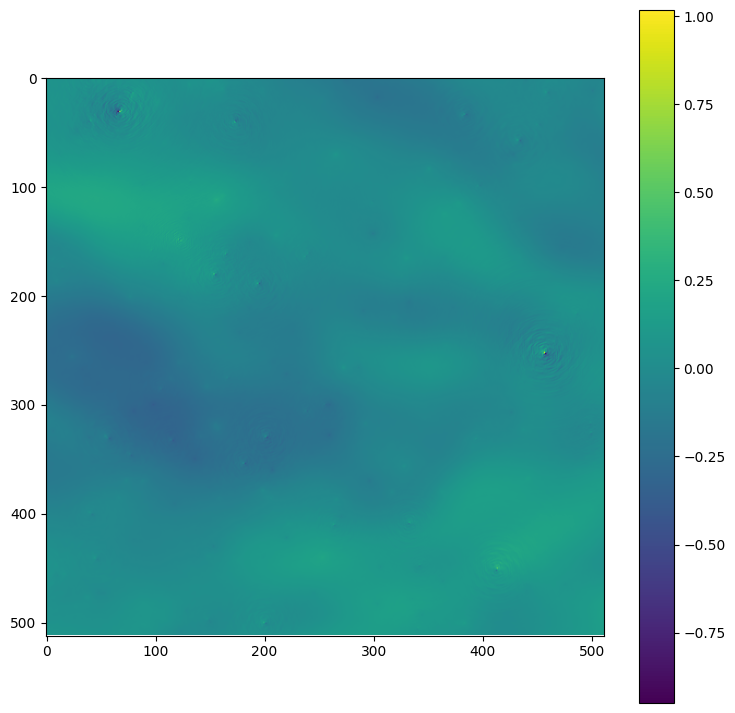

In [32]:
plt.figure(figsize= (9,9))
plt.imshow(subtract_img[0,:,:])
plt.colorbar()

In [33]:
fits.writeto(base + 'bright_source_removed.fits',subtract_img,overwrite=True)


In [35]:
fits.writeto(base + 'bright_source_removed_1.fits',subtract_img[0:150,:,:],overwrite=True)

In [36]:
fits.writeto(base + 'bright_source_removed_2.fits',subtract_img[150:300,:,:],overwrite=True)

In [37]:
fits.writeto(base + 'bright_source_removed_3.fits',subtract_img[300:450,:,:],overwrite=True)

In [38]:
fits.writeto(base + 'bright_source_removed_4.fits',subtract_img[450:600,:,:],overwrite=True)

In [39]:
fits.writeto(base + 'bright_source_removed_5.fits',subtract_img[600:750,:,:],overwrite=True)

In [40]:
fits.writeto(base + 'bright_source_removed_6.fits',subtract_img[750:900,:,:],overwrite=True)

In [34]:
fits.writeto(base + 'point_source_model.fits',conv_img1d,overwrite=True) #just one slice